# Exploratory Data Analysis
    
The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics.

- The **training data** is a single, continuous segment of experimental data. 
- The **test data** consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each *seg_id* in the test folder, you should predict a single *time_to_failure* corresponding to the time between the last row of the segment and the next laboratory earthquake.

[Scores](https://docs.google.com/spreadsheets/d/1AWLPZfryFWx6wM9fxmMmGm31R4B9PMrZzLp71ZtlcRk/edit#gid=0)

In [1]:
# Convenience
import warnings
from tqdm import tqdm

import random
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Machine Learning libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve, auc
from sklearn import linear_model

warnings.filterwarnings("ignore")

random.seed(1)
pd.options.display.precision = 15

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

[Earthquakes FE. More features and samples](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples)<br/>
[Seismic data EDA and baseline](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)<br/>
[Shaking Earth](https://www.kaggle.com/allunia/shaking-earth)

## Loading data

In [3]:
df_train = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
df_train = reduce_memory_usage(df_train)
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage: 3600.00 MB
Reduced memory usage: 2400.00 MB (33.3% reduction)
629,145,480 records and 2 features in train set.


## Feature extraction

In [4]:
rows = 150_000
segments = int(np.floor(df_train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = df_train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 4194/4194 [00:16<00:00, 248.70it/s]


## Feature selection

## Training

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

### Nu Support Vector Regression

In [ ]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
NuSVR_MAE_score = mean_absolute_error(y_train.values.flatten(), y_pred)
print('MAE: {:.5f}'.format(NuSVR_MAE_score))

In [ ]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))
print('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))

### Machine Learning Algorithms

In [9]:
MLA = [
    # Linear models
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(alpha=0.1),
    linear_model.ElasticNet(),
    linear_model.LassoLars(alpha=.1),
    linear_model.BayesianRidge(),
    linear_model.SGDRegressor(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.RANSACRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.HuberRegressor(),

    # SVR
    NuSVR(),

    # LightGBM
    lgb.LGBMRegressor(learning_rate=0.05)   
]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .25, train_size = .75, random_state = 0 )

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = X_train

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train_scaled, y_train, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train_scaled, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train_scaled)

    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

LinearRegression
Ridge
Lasso
ElasticNet
LassoLars
BayesianRidge
SGDRegressor
PassiveAggressiveRegressor
RANSACRegressor
TheilSenRegressor
HuberRegressor
NuSVR
LGBMRegressor


In [10]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
11,NuSVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.357567755499649,0.350300060048647,0.0514824641879457,0.521807765960693
12,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.556353439663867,0.349089779257175,0.0695470015841627,0.0911734580993652
5,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",0.0550546796413919,0.0446736478489484,0.0541833235501411,0.00368928909301758
1,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.0551693326727262,0.044309210936094,0.0586217057532036,0.00474357604980469
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.0551705636178839,0.0441709104981262,0.059517092073804,0.00487165451049805
2,Lasso,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",0.046451487991976,0.0436330747378471,0.0173717666325946,0.00470154285430908
6,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",0.0474314374827146,0.0360501530500266,0.058010327605715,0.00621054172515869
3,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.021363994143529,0.0187072634394731,0.00702195455703102,0.00494704246520996
4,LassoLars,"{'alpha': 0.1, 'copy_X': True, 'eps': 2.220446...",0,-0.00218488196973265,0.00761095952837273,0.0044971227645874
10,HuberRegressor,"{'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...",-0.353129781037742,-0.508216818018665,2.06447191889115,0.0227333784103394


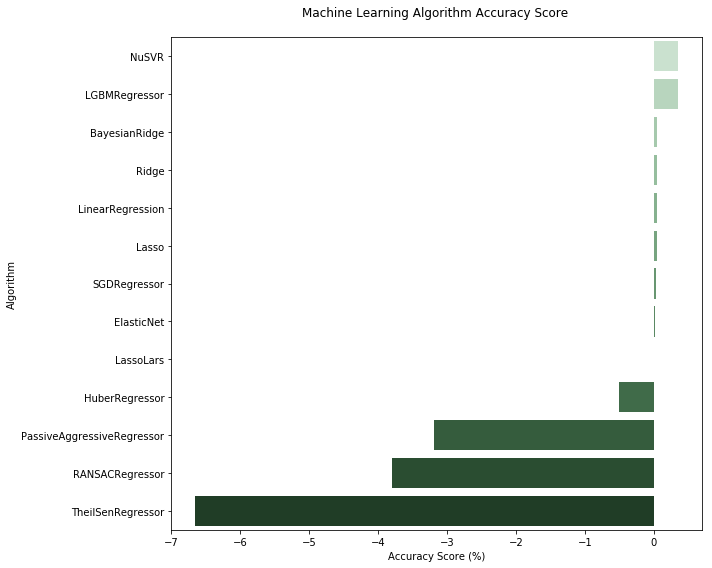

In [11]:
plt.figure(figsize=(10, 8))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.cubehelix_palette(len(MLA_compare), start=2, rot=0, dark=0.2, light=.85, reverse=False))

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.tight_layout()

In [ ]:
def create_submission(model, output_filename, mae_score):
    submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')
    output = pd.DataFrame(columns=['ave', 'std', 'max', 'min'], dtype=np.float64, index=submission.index)
    for seg_id in output.index:
        seg = pd.read_csv('input/test/' + seg_id + '.csv')
        x = seg['acoustic_data'].values

        output.loc[seg_id, 'ave'] = x.mean()
        output.loc[seg_id, 'std'] = x.std()
        output.loc[seg_id, 'max'] = x.max()
        output.loc[seg_id, 'min'] = x.min()

    output_scaled = scaler.transform(output)

    submission['time_to_failure'] = model.predict(output_scaled)
    submission.to_csv(output_filename.format(mae_score))
    print(output_filename.format(mae_score))

In [ ]:
model_sgd = linear_model.SGDRegressor()
model_sgd.fit(X_train_scaled, y_train.values.flatten())
y_pred = model_sgd.predict(X_train_scaled)
mae_score = mean_absolute_error(y_train.values.flatten(), y_pred)

create_submission(model_sgd, 'output/NuSVR_MAE{:.5f}.csv', mae_score)

### GridSearch
[Parameters to tune](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [ ]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.05)
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.25, train_size=.75, random_state=1)
base_results = model_selection.cross_validate(model_lgb, X_train, y_train, cv=cv_split)
model_lgb.fit(X_train, y_train)

print('BEFORE DT Parameters: ', model_lgb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

param_grid = {
    'boosting': ['gbdt', 'dart'],
    'lambda': [0.01, 0.1],
    'learning_rate': [0.003, 0.01, 0.03],
    #'max_depth': [10, 25],
    'num_leaves': [10, 20]
}

tune_model = model_selection.GridSearchCV(lgb.LGBMRegressor(), param_grid=param_grid, scoring = 'neg_mean_absolute_error', cv = cv_split, verbose=1, n_jobs=4)
tune_model.fit(X_train, y_train)

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

BEFORE DT Parameters:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
BEFORE DT Training w/bin score mean: 75.77
BEFORE DT Test w/bin score mean: 59.04
BEFORE DT Test w/bin score 3*std: +/- 4.75
----------
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s


### Ensembling

### Stacking